In [47]:
# import requied libraries
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np
from PIL import Image
from pyquaternion import Quaternion
from tqdm import tqdm
import os
import os.path as osp

import json
import math

import sys
import time
from datetime import datetime
from typing import Tuple, List, Iterable

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

from matplotlib import rcParams
from matplotlib.axes import Axes


from nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud

from nuscenes.utils.geometry_utils import view_points

# define a NuScenes object
nusc = NuScenes(version='v1.0-mini', dataroot='/home/car/Documents/nuscenes-devkit/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.383 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [2]:
# read in an example scene
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [3]:
# get sample token
first_sample_token = my_scene['first_sample_token']

my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [4]:
# read in the radar record
sensor = 'RADAR_FRONT'
radar_rec = nusc.get('sample_data', my_sample['data'][sensor])
radar_rec

{'token': '37091c75b9704e0daa829ba56dfa0906',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '37091c75b9704e0daa829ba56dfa0906',
 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'timestamp': 1532402927664178,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402927664178.pcd',
 'prev': '',
 'next': 'f0b8593e08594a3eb1152c138b312813',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

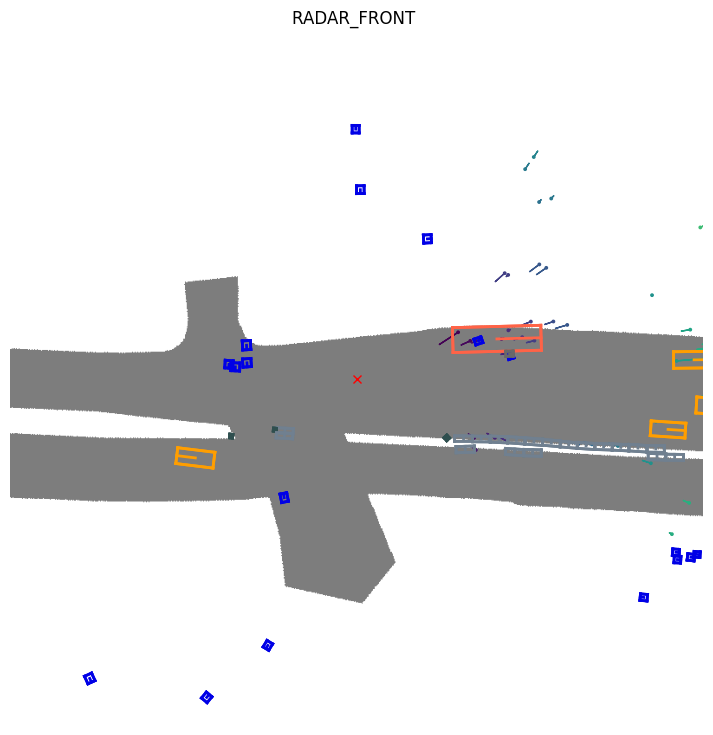

In [5]:
# render the radar data (just to show that the record was read in correctly)
nusc.render_sample_data(radar_rec['token'])

In [12]:
pc = RadarPointCloud.from_file(osp.join(nusc.dataroot, radar_rec['filename']))

pc.points[1]

array([  5.30000019,   4.30000019,   4.5       ,  -6.9000001 ,
        -8.30000019,   4.5       ,  -6.9000001 ,   2.9000001 ,
         5.5       ,  -7.30000019,   4.69999981,   4.30000019,
         6.5       ,  12.10000038,  11.89999962,   6.5       ,
         6.0999999 ,  13.10000038,  12.69999981,  -7.69999981,
        -7.69999981,  20.29999924,  -7.9000001 ,  20.70000076,
        24.10000038,  25.5       ,  -5.0999999 ,  -9.89999962,
         9.5       ,   1.89999998,   5.5       ,  -2.29999995,
         3.29999995, -18.10000038,   3.9000001 , -14.5       ,
        17.29999924,  -9.30000019,  -5.30000019,   6.30000019,
        -5.69999981,   8.5       , -11.5       ,  -9.30000019,
        -6.0999999 ,  26.10000038,  -9.30000019,   7.5       ,
        29.89999962,  20.70000076,  29.29999924,   1.29999995,
        31.5       ,  32.5       ,  -0.30000001,  -6.5       ,
        26.10000038, -17.29999924,   1.70000005, -49.70000076,
         6.30000019, -38.09999847,  -0.69999999, -22.10

In [6]:
def get_radar_sample_points(nusc: NuScenes,
                            radar_rec,
                            min_dist: float = 3.0,
                            max_dist: float = 30.0,
                           verbose = True):

    # get the radar point cloud
    pc = RadarPointCloud.from_file(osp.join(nusc.dataroot, radar_rec['filename']))



    # Points live in their own reference frame. So they need to be transformed via global to the image plane.
    # First step: transform the point cloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', radar_rec['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Optional Filter by distance to remove the ego vehicle.
    dists_origin = np.sqrt(np.sum(pc.points[:3, :] ** 2, axis=0))
    keep = np.logical_and(min_dist <= dists_origin, dists_origin <= max_dist)
    pc.points = pc.points[:, keep]
    #coloring = coloring[:, keep]
    if verbose:
        print('Distance filter: Keeping %d of %d points...' % (keep.sum(), len(keep)))

    # Second step: transform to the global frame.
    poserecord = nusc.get('ego_pose', radar_rec['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))
    
    return pc

In [7]:
radar_pointclouds = get_radar_sample_points(nusc, radar_rec)
radar_pointclouds.points

Distance filter: Keeping 22 of 74 points...


array([[ 4.12256438e+02,  4.10837981e+02,  4.10615377e+02,
         4.00178422e+02,  3.98794664e+02,  4.09794358e+02,
         3.99357403e+02,  4.08017438e+02,  4.10460213e+02,
         3.98502663e+02,  4.09161244e+02,  4.08306504e+02,
         4.10510304e+02,  4.16797940e+02,  4.16473197e+02,
         4.09620866e+02,  4.08697709e+02,  4.16369103e+02,
         4.15719618e+02,  3.95321702e+02,  3.94774355e+02,
         4.23133709e+02],
       [ 1.16802412e+03,  1.16705049e+03,  1.16585461e+03,
         1.17050294e+03,  1.17079356e+03,  1.16359957e+03,
         1.16824790e+03,  1.16339479e+03,  1.16250608e+03,
         1.16706919e+03,  1.16127617e+03,  1.16009746e+03,
         1.15972131e+03,  1.16062596e+03,  1.16031849e+03,
         1.15727835e+03,  1.15591172e+03,  1.15652576e+03,
         1.15591080e+03,  1.15950120e+03,  1.15799784e+03,
         1.15406472e+03],
       [ 2.56821194e-01,  2.62281933e-01,  2.44521475e-01,
         4.95531390e-01,  5.22998219e-01,  2.17491779e-01,
    

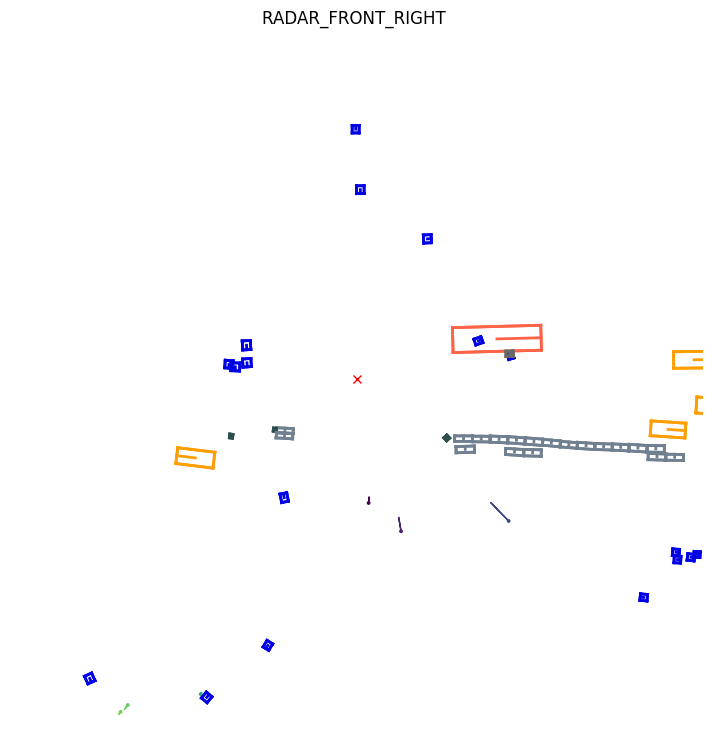

In [86]:
nusc.render_sample_data(my_sample['data']['RADAR_FRONT_RIGHT'], nsweeps=5, underlay_map=False)

In [13]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix

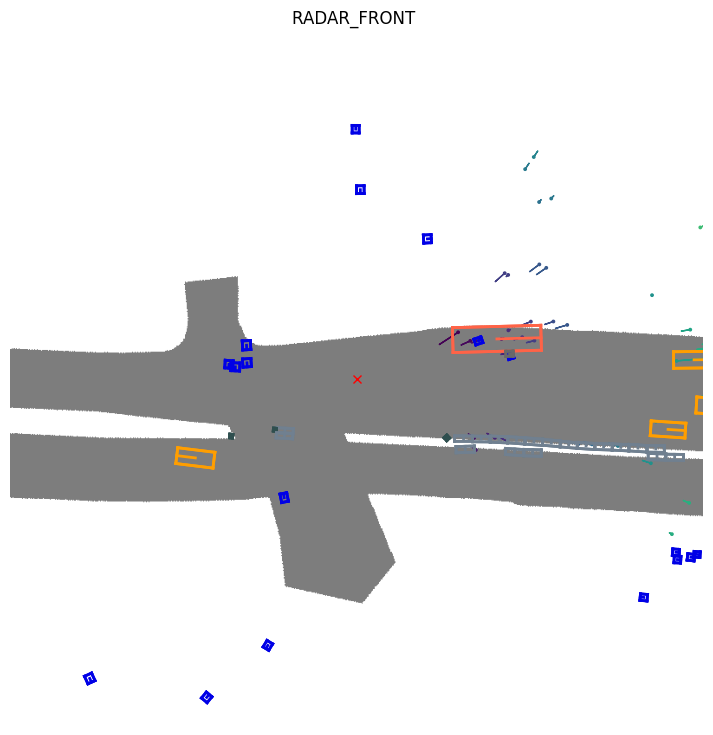

In [92]:
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)

In [88]:
# 2nd attempt to extract radar points

def get_radar_sample_points2(nusc: NuScenes,
                            radar_rec,
                            min_dist: float = 3.0,
                            max_dist: float = 30.0,
                             axes_limit: float = 40,
                           verbose = True):

    # get the radar point cloud
    pc = RadarPointCloud.from_file(osp.join(nusc.dataroot, radar_rec['filename']))
    
    # note: the following is the structure of the point cloud format:
    # FIELDS x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0 vx_rms vy_rms
    
    # from this, we can see that the x, y and z coordinates of the radar points are in the first 3 fields of the point cloud
    
    # read in the data needed to trasfrom to global z plane
    cs_record = nusc.get('calibrated_sensor', radar_rec['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', radar_rec['ego_pose_token'])
    

    ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                              rotation=Quaternion(cs_record["rotation"]))

    # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
    ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
    rotation_vehicle_flat_from_vehicle = np.dot(
    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
    Quaternion(pose_record['rotation']).inverse.rotation_matrix)
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
    viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)
    
    points = view_points(pc.points[:3, :], viewpoint, normalize=False) # x,y,z radar points
    dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))  # distances
    colors = np.minimum(1, dists / axes_limit / np.sqrt(2))  # colors
    
    # for now, just return points. We can also return distances
    return points

In [89]:
# read in the radar record
sensor = 'RADAR_FRONT'
radar_rec = nusc.get('sample_data', my_sample['data'][sensor])
radar_rec

{'token': '37091c75b9704e0daa829ba56dfa0906',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '37091c75b9704e0daa829ba56dfa0906',
 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'timestamp': 1532402927664178,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402927664178.pcd',
 'prev': '',
 'next': 'f0b8593e08594a3eb1152c138b312813',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

In [90]:
radar_points = get_radar_sample_points2(nusc, radar_rec)

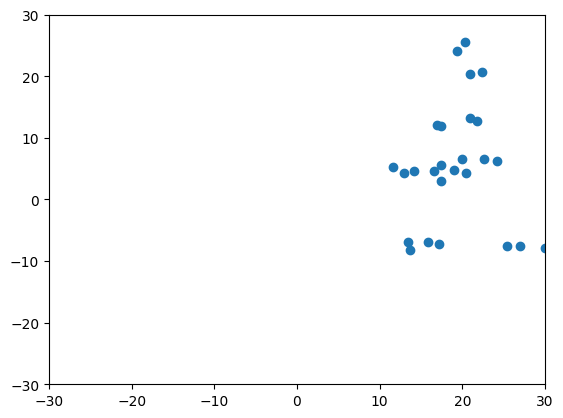

In [91]:
plt.figure()
plt.scatter(radar_points[0], radar_points[1])
plt.xlim([-30, 30]) # for now, just showing points within 30m (I think). There are more points detected beyond this range, however
plt.ylim([-30, 30])
plt.show()